![alt text](tacotron2_tts_pipeline.png)

![alt text](tacotron2_diagram.png)

In [10]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt
import string

torch.random.manual_seed(9)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.2.2+cpu
2.2.2+cpu
cpu


#### 1. Text based processing

In [11]:

symbols = "_-!'(),.:;? " + string.ascii_lowercase
look_up = {symbol: i for i, symbol in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
	text = text.lower()
	return [look_up[symbol] for symbol in text if symbol in symbols]

text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [12]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
text = "Hello world! Text to speech!"
processed_text, lengths = processor(text)
print(processed_text, lengths)
print([processor.tokens[i] for i in processed_text[0, : lengths[0]]])

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]]) tensor([28], dtype=torch.int32)
['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


#### 2. Phoneme-based encoding

In [13]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH
processor = bundle.get_text_processor()
text = "Attahiru"
with torch.inference_mode():
	processed_text, lengths = processor(text)

print(processed_text, lengths)
print([processor.tokens[i] for i in processed_text[0, : lengths[0]]])

tensor([[12, 81, 12, 54, 55, 78, 87]]) tensor([7], dtype=torch.int32)
['AA', 'T', 'AA', 'HH', 'IH', 'R', 'UW']


c:\Users\AttahiruJibril\.conda\envs\ML-AI\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### 3. Spectogram Generation

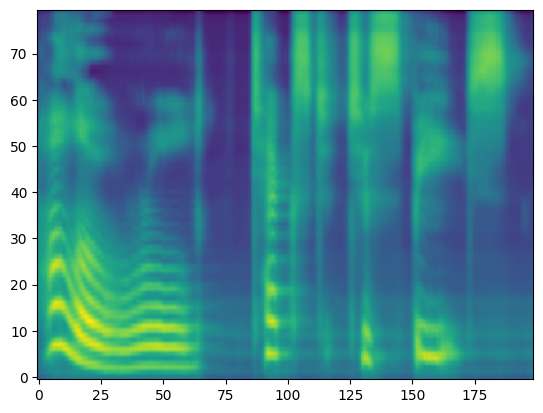

In [14]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
	processed_text, lengths = processor(text)
	processed_text = processed_text.to(device)
	lengths = lengths.to(device)
	spectogram, _, _ = tacotron2.infer(processed_text, lengths)

_ = plt.imshow(spectogram[0].cpu().detach(), origin='lower', aspect='auto')

torch.Size([80, 181])
torch.Size([80, 188])
torch.Size([80, 232])


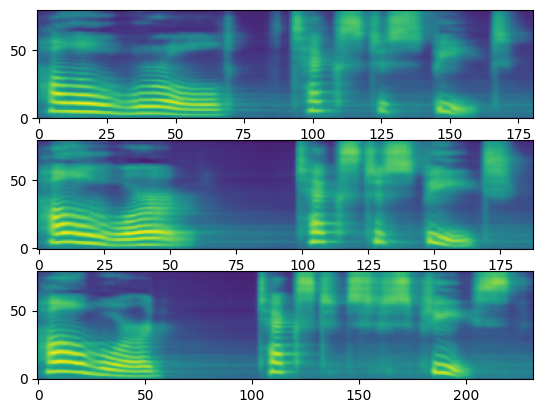

In [15]:
def plotter():
	fig, ax = plt.subplots(3,1)
	for i in range(3):
		with torch.inference_mode():
			spec, spen_len, _ = tacotron2.infer(processed_text, lengths)
		print(spec[0].shape)
		ax[i].imshow(spec[0].cpu().detach(), origin='lower', aspect='auto')

plotter()

#### 4. Waveform Generation

In [19]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed_text, lengths = processor(text)
    processed_text = processed_text.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed_text, lengths)
    waveform, lengths = vocoder(spec, spec_lengths)

Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to C:\Users\AttahiruJibril/.cache\torch\hub\checkpoints\wavernn_10k_epochs_8bits_ljspeech.pth
100%|██████████| 16.7M/16.7M [00:11<00:00, 1.53MB/s]
